In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width: 98% !important }</style>'))

In [2]:
from utilities import *

In [3]:
import joblib
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
from sklearn.preprocessing import normalize
import seaborn as sns

sns.set()

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Import Data

In [5]:
pin = read_pin('../Data/pin.csv')
test_pin = read_pin('../Data/testPin.csv')
ble = read_ble('../Data/ble.csv')

In [6]:
data_1 = read_data('../Data/rssi5.csv')
data_2 = read_data('../Data/rssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [7]:
def read_sequence_rssi(filename):
    rssi = pd.read_csv(filename)
    rssi = rssi.pivot_table(columns="scanner", values="rssi", index="time")
    rssi.rename_axis(None, axis=1, inplace=True)
    rssi.index = pd.to_datetime(rssi.index)
    rssi = rssi.groupby(pd.Grouper(freq='100ms')).mean()
    return rssi

def read_sequence_loc(filename):
    loc = pd.read_csv(filename)
    loc['time'] = pd.to_datetime(loc['time'])
    loc.set_index('time', inplace=True)
    loc = loc.groupby(pd.Grouper(freq='100ms')).mean()
    return loc

In [8]:
rssi = read_sequence_rssi('../Data/sequenceRssi5.csv')
loc = read_sequence_loc('../Data/sequenceLoc5.csv')

In [9]:
def transform(loc, inplace=False):
    if inplace:
        loc['X'] = 24.187023 + loc['X']
        loc['Y'] = 12.252072 - loc['Y']
    else:
        transformed = pd.DataFrame()
        transformed['X'] = 24.187023 + loc['X']
        transformed['Y'] = 12.252072 - loc['Y']
        return transformed

In [10]:
transform(loc, inplace=True)

In [11]:
loc = loc.interpolate(method='linear')
loc = loc[loc['X'] >= 11.5]

In [12]:
data_3 = rssi.join(loc, how='inner')
data_3.shape

(6424, 19)

In [13]:
test_1 = read_data('../Data/testRssi.csv')
test_2 = read_data('../Data/testRssi_2.csv')

All beacons: ['0117C55D14E4']
Selecting all
All beacons: ['0117C55D14E4']
Selecting all


In [14]:
test_rssi = read_sequence_rssi('../Data/testSequenceRssi.csv')
test_loc = read_sequence_loc('../Data/testSequenceLoc.csv')

In [15]:
transform(test_loc, inplace=True)

In [16]:
test_loc = test_loc.interpolate(method='linear')
test_loc = test_loc[test_loc['X'] >= 11.5]

In [17]:
test_3 = test_rssi.join(test_loc, how='inner')
test_3.shape

(1791, 19)

In [18]:
data = pd.concat([data_1, data_2, data_3], axis=0, sort=True)
test = pd.concat([test_1, test_2], axis=0, sort=True)

In [19]:
test.shape

(27229, 19)

## Train Validation Split

In [20]:
train, validation = train_validation_split(data)

In [21]:
print(train.shape)
print(validation.shape)

(107814, 21)
(11980, 21)


In [22]:
def linear_impute(data):
    for s in scanners:
        dx = data['X'] - ble[s]['X']
        dy = data['Y'] - ble[s]['Y']
        d = np.sqrt(np.square(dy) + np.square(dx))
        reg = joblib.load('../Models/linear_distance_models_2/{}.joblib'.format(s))
        ss = pd.Series(reg.predict(d.values.reshape((-1, 1))))
        data[s].fillna(ss, inplace=True)

def impute(data):
    rolling_win = 30

    data = data.sort_values("time")
    data_rolled = data.groupby("location").rolling(rolling_win, min_periods=1).mean().reset_index()
    data_imputed = data_rolled.set_index("location").groupby("location").ffill()
    data_imputed.reset_index(inplace=True)
    data_imputed["X"] = data_imputed["location"].apply(lambda x: pin[x]["X"] if x[0] == 'V' else test_pin[x]["X"])
    data_imputed["Y"] = data_imputed["location"].apply(lambda x: pin[x]["Y"] if x[0] == 'V' else test_pin[x]["Y"])
    linear_impute(data_imputed)
    return data_imputed

In [23]:
train_imputed = impute(train)
validation_imputed = impute(validation)
test_imputed = impute(test)

In [24]:
train_imputed[scanners] = normalize(train_imputed[scanners] + 100)
validation_imputed[scanners] = normalize(validation_imputed[scanners] + 100)
test_imputed[scanners] = normalize(test_imputed[scanners] + 100)

In [25]:
train_imputed

,location,level_1,C400A2E19293,CD4533FFC0E1,D2B6503554D7,DB8B36A69C56,DD697EA75B68,DF231643E227,E13B805C6CB0,E43355CA8B96,...,E8FD0B453DC4,E96AF2C858BA,EC72840D9AD3,F1307ECB3B90,F1EDAF28E08A,F69A86823B96,FB2EE01C18CE,FDAE5980F28C,X,Y
0,V1_10,30171,0.270859,0.233392,0.211301,0.353549,0.281666,0.193480,0.167370,0.284954,...,0.207280,0.113343,0.307202,0.356753,0.255005,0.218772,0.043828,0.278136,11.17660,5.29753
1,V1_10,30172,0.269998,0.232650,0.210630,0.352425,0.280771,0.192865,0.184881,0.284048,...,0.206622,0.112983,0.306226,0.355619,0.254194,0.218076,0.043688,0.277252,11.17660,5.29753
2,V1_10,30173,0.323051,0.228668,0.207025,0.346393,0.275966,0.189564,0.181716,0.279187,...,0.203085,0.111049,0.300985,0.349533,0.249844,0.214344,0.042941,0.272507,11.17660,5.29753
3,V1_10,30176,0.322614,0.228359,0.206745,0.345925,0.275592,0.189307,0.181471,0.278809,...,0.202811,0.110899,0.300577,0.352859,0.249506,0.214054,0.042883,0.272206,11.17660,5.29753
4,V1_10,30177,0.323185,0.228763,0.207111,0.346537,0.276080,0.189643,0.181792,0.279303,...,0.203170,0.111095,0.301110,0.348434,0.249948,0.214433,0.042959,0.272688,11.17660,5.29753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102050,V1_9,31037,0.272912,0.159663,0.211646,0.328608,0.167089,0.100253,0.222785,0.412153,...,0.200507,0.100253,0.306330,0.263629,0.303545,0.206076,0.066836,0.367595,8.17867,5.28213
102051,V1_9,31039,0.275097,0.160941,0.213341,0.312151,0.168427,0.101056,0.224569,0.415453,...,0.202112,0.101056,0.308783,0.265740,0.305976,0.198370,0.067371,0.370539,8.17867,5.28213
102052,V1_9,31040,0.275097,0.140356,0.213341,0.312151,0.168427,0.123513,0.224569,0.415453,...,0.202112,0.101056,0.310654,0.265740,0.305976,0.198370,0.067371,0.370539,8.17867,5.28213
102053,V1_9,31042,0.273806,0.139697,0.212339,0.310686,0.167636,0.122933,0.223515,0.424679,...,0.201164,0.100582,0.309196,0.264493,0.304539,0.197438,0.067055,0.368800,8.17867,5.28213


## Model Training

In [26]:
X_train, y_train = train_imputed[scanners].values, train_imputed[["X", "Y"]].values
X_validation, y_validation = validation_imputed[scanners].values, validation_imputed[["X", "Y"]].values
X_test, y_test = test_imputed[scanners].values, test_imputed[["X", "Y"]].values

In [27]:
optimizer = tf.keras.optimizers.Adam(0.00005)
loss = "mse"
metrics = ["mae", "mse"]
batch_size = 32
epochs = 10000

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_loss')
]

inputs = tf.keras.Input(shape=(17,))
x = tf.keras.layers.Dense(128, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.Dense(1)(x)

y = tf.keras.layers.Dense(128, activation='relu')(inputs)
y = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(y)
y = tf.keras.layers.Dense(1)(y)

outputs = tf.keras.layers.Concatenate(axis=1)([x, y])

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          2304        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           8256        dense[0][0]                      
______________________________________________________________________________________________

In [29]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Train on 102055 samples, validate on 27229 samples
Epoch 1/10000
102055/102055 [==============================] - 7s 64us/sample - loss: 41.0242 - mae: 4.0752 - mse: 40.7776 - val_loss: 3.4919 - val_mae: 1.5275 - val_mse: 3.2769
Epoch 2/10000
102055/102055 [==============================] - 6s 55us/sample - loss: 2.4621 - mae: 1.1768 - mse: 2.2579 - val_loss: 2.8015 - val_mae: 1.2811 - val_mse: 2.6055
Epoch 3/10000
102055/102055 [==============================] - 6s 54us/sample - loss: 1.9937 - mae: 1.0209 - mse: 1.8000 - val_loss: 2.7738 - val_mae: 1.2738 - val_mse: 2.5800
Epoch 4/10000
102055/102055 [==============================] - 5s 51us/sample - loss: 1.7667 - mae: 0.9382 - mse: 1.5701 - val_loss: 2.7748 - val_mae: 1.2771 - val_mse: 2.5745
Epoch 5/10000
102055/102055 [==============================] - 6s 54us/sample - loss: 1.5790 - mae: 0.8652 - mse: 1.3739 - val_loss: 2.7480 - val_mae: 1.2721 - val_mse: 2.5381
Epoch 6/10000
102055/102055 [==============================] - 5s 4

102055/102055 [==============================] - 4s 37us/sample - loss: 0.3928 - mae: 0.3069 - mse: 0.2135 - val_loss: 2.0390 - val_mae: 1.0365 - val_mse: 1.8603
Epoch 48/10000
102055/102055 [==============================] - 4s 36us/sample - loss: 0.3884 - mae: 0.3039 - mse: 0.2103 - val_loss: 2.0821 - val_mae: 1.0594 - val_mse: 1.9046
Epoch 49/10000
102055/102055 [==============================] - 4s 37us/sample - loss: 0.3844 - mae: 0.3017 - mse: 0.2075 - val_loss: 2.0564 - val_mae: 1.0488 - val_mse: 1.8801
Epoch 50/10000
102055/102055 [==============================] - 4s 36us/sample - loss: 0.3803 - mae: 0.2991 - mse: 0.2046 - val_loss: 2.0383 - val_mae: 1.0368 - val_mse: 1.8631
Epoch 51/10000
102055/102055 [==============================] - 4s 37us/sample - loss: 0.3769 - mae: 0.2974 - mse: 0.2023 - val_loss: 2.0151 - val_mae: 1.0282 - val_mse: 1.8411
Epoch 52/10000
102055/102055 [==============================] - 4s 36us/sample - loss: 0.3731 - mae: 0.2951 - mse: 0.1997 - val_lo

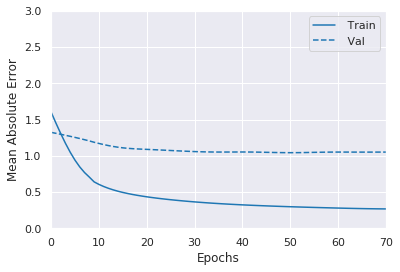

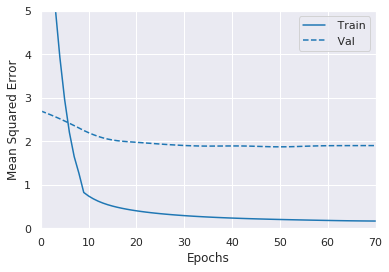

In [30]:
plt.figure()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({"": history}, metric = "mae")
plt.ylim([0, 3])
plt.ylabel('Mean Absolute Error')

plt.figure()
plotter.plot({"": history}, metric = "mse")
plt.ylim([0, 5])
plt.ylabel('Mean Squared Error')

plt.show()

## Model Validation

In [31]:
def inv_scale(y):
    ret_y = np.copy(y)
    ret_y[:, 0] = ret_y[:, 0] * 33.5
    ret_y[:, 1] = ret_y[:, 1] * 16.8
    return ret_y

def average_distance_error(preds, y_test, scaled=False):
    if scaled:
        preds = inv_scale(preds)
        y_test = inv_scale(y_test)
    return np.mean(np.sqrt(np.sum(np.square(preds - y_test), axis=1)))

In [32]:
def cdf(preds, y_test, test_data=False):
    cpin = test_pin if test_data else pin
    plt.figure(figsize=(5, 5))
    for loc in cpin.keys():
        x_selector = np.isclose(y_test[:, 0], cpin[loc]['X'], atol=0.01)
        y_selector = np.isclose(y_test[:, 1], cpin[loc]['Y'], atol=0.01)
        selector = np.logical_and(x_selector, y_selector)
        selector = selector.reshape(-1)
        Z = np.sqrt(np.sum(np.square(preds[selector] - y_test[selector]), axis=1))
        N = Z.size

        X = np.sort(Z)
        F = np.array(range(N)) / float(N)

        plt.plot(X, F, label=loc)
    plt.title('CDF of Euclidean Distance Error')
    plt.xlabel('Euclidean Distance Error (m)')
    plt.ylabel('Density')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

11315/1 - 0s - loss: 0.3501 - mae: 0.3738 - mse: 0.3478
Validation loss: 0.5025001556892812
Mean absolute error: 0.37382308
Mean squared error: 0.3477831
Average distance error: 0.6145646661772136


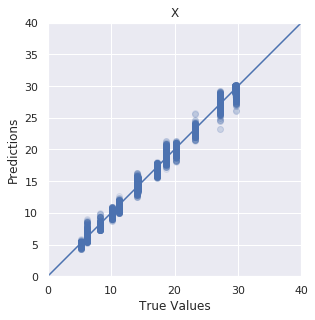

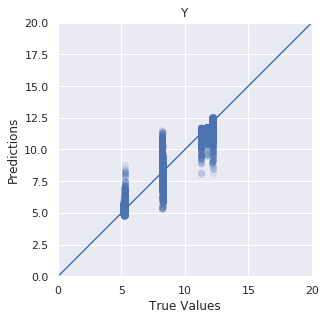

In [33]:
validation_scores = model.evaluate(X_validation, y_validation, verbose=2)
print("Validation loss:", validation_scores[0])
print("Mean absolute error:", validation_scores[1])
print("Mean squared error:", validation_scores[2])

preds = model.predict(X_validation)
print("Average distance error:", average_distance_error(preds, y_validation))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_validation[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

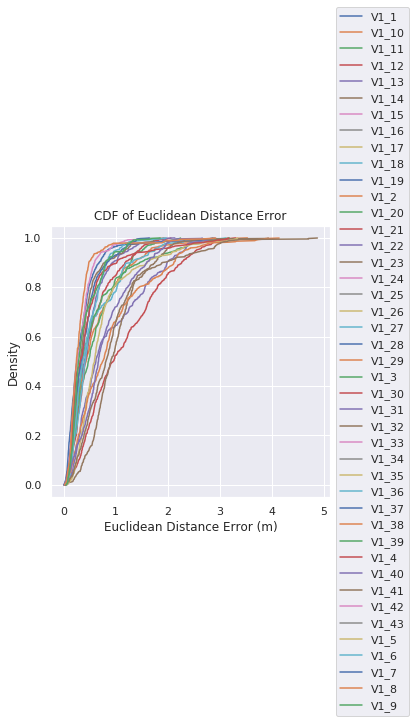

In [34]:
cdf(preds, y_validation)

## Model Testing

27229/1 - 0s - loss: 1.7905 - mae: 1.0500 - mse: 1.9021
Test loss: 2.05681236188478
Mean absolute error: 1.0500364
Mean squared error: 1.9020956
Average distance error: 1.7018650558745243


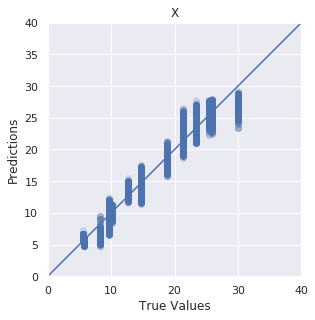

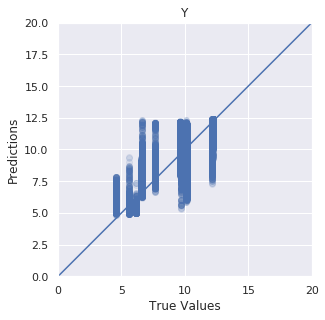

In [35]:
test_scores = model.evaluate(X_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Mean absolute error:", test_scores[1])
print("Mean squared error:", test_scores[2])

preds = model.predict(X_test)
print("Average distance error:", average_distance_error(preds, y_test))

fig = plt.figure(figsize=(10, 20))
lims = [0, 40]
ax1 = fig.add_subplot(121, aspect='equal', title='X', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')
ax1.scatter(y_test[:, 0], preds[:, 0], alpha=0.1)
ax1.plot(lims, lims)

fig = plt.figure(figsize=(10, 20))
lims = [0, 20]
ax1 = fig.add_subplot(121, aspect='equal', title='Y', xlim=lims, ylim=lims, xlabel='True Values', ylabel='Predictions')

ax1.scatter(y_test[:, 1], preds[:, 1], alpha=0.1)
ax1.plot(lims, lims)

plt.show()

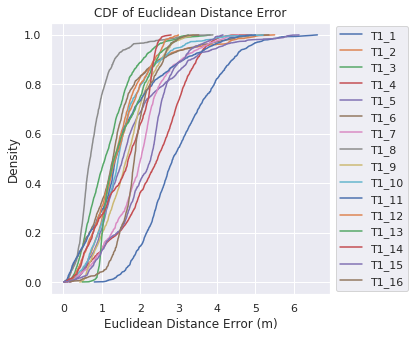

In [36]:
cdf(preds, y_test, test_data=True)

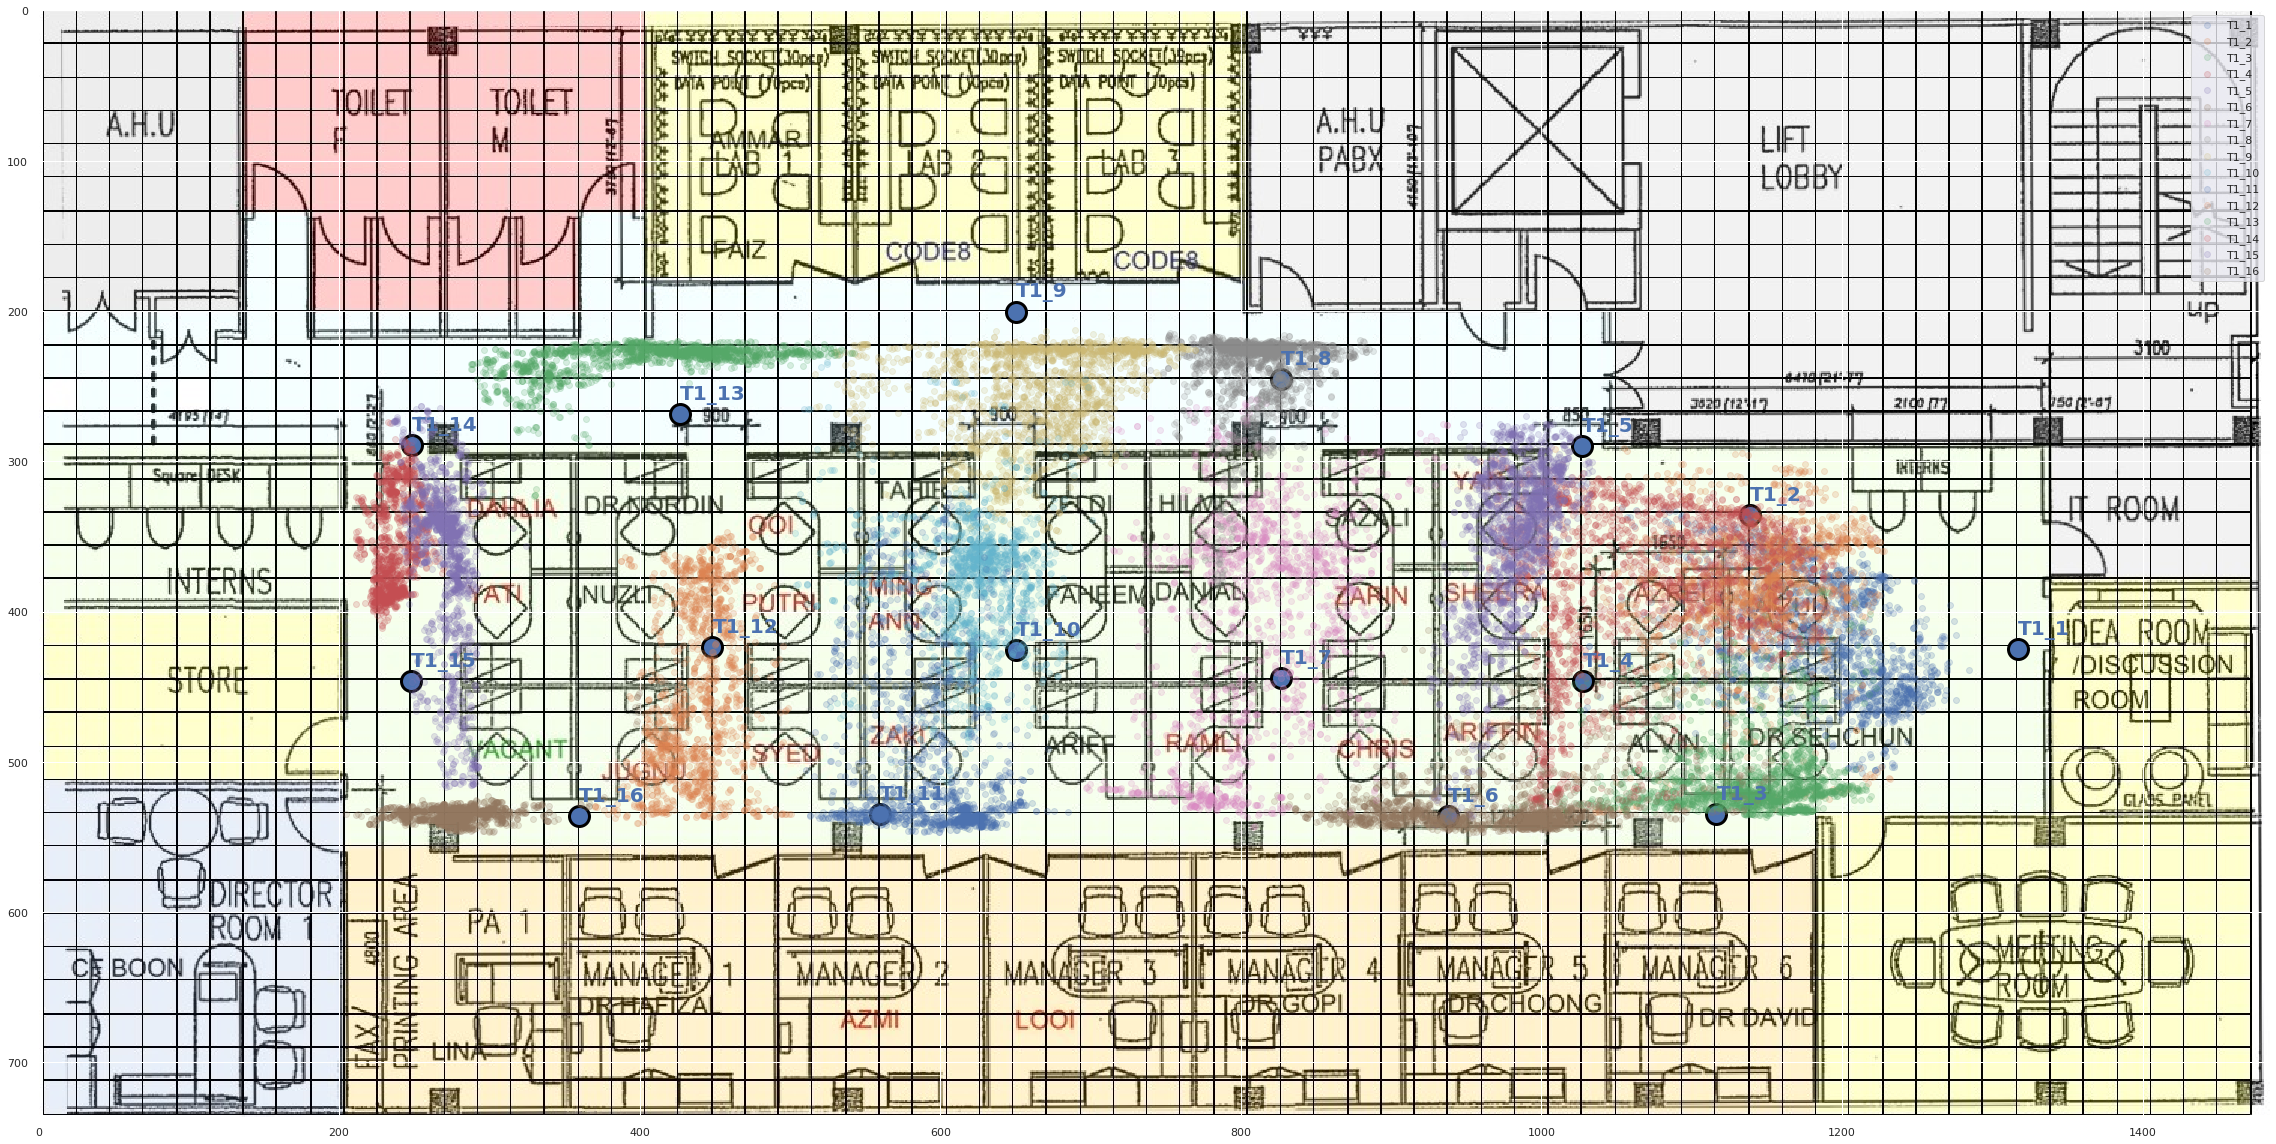

In [37]:
img =  mpimg.imread('../Map/main.png')
fingerprint_color = "r"
testdata_color = "b"
plt.figure(figsize=(40,40))
plt.imshow(img)

labels = ["V1_23", "V1_24", "V1_32", "V1_22", "V1_14", "V1_13", "V1_12", "V1_21", "V1_29", "V1_30", "V1_31", "V1_11", "V1_20", "V1_28", "V1_10", "V1_19", "V1_27", "V1_9", "V1_8", "V1_18", "V1_26"]
x = [27.151600, 29.594400, 29.689400, 23.153700, 23.169100, 20.171700, 17.173201, 18.712299, 18.691700, 23.244200, 27.133301, 14.063600, 14.159800, 14.250300, 11.176600, 10.162500, 10.141900, 8.178670, 5.180690, 6.164600, 6.255650]
y = [8.159480, 8.172020, 11.286000, 8.250140, 5.247920, 5.121330, 5.217130, 8.227330, 12.230300, 12.253700, 11.717700, 5.312350, 8.203950, 12.207500, 5.297530, 8.183420, 12.186400, 5.282130, 5.266730, 8.274090, 12.166400]
x = np.array(x) * 44
y = np.array(y) * 44

testLabels = ["T1_1", "T1_2", "T1_3", "T1_4", "T1_5", "T1_6", "T1_7", "T1_8", "T1_9", "T1_10", "T1_11", "T1_12", "T1_13", "T1_14", "T1_15", "T1_16"]
testX = [29.934250, 25.877805, 25.372470, 23.355726, 23.333564, 21.316819, 18.790348, 18.790348, 14.779021, 14.779021, 12.717952, 10.191480, 9.703916, 5.648265, 5.626103, 8.174736]
testY = [9.659024, 7.630801, 12.155781, 10.139037, 6.593112, 12.177943, 10.094712, 5.573659, 4.554205, 9.673634, 12.155781, 9.629310, 6.105547, 6.570950, 10.139037, 12.177943]
testX = np.array(testX) * 44
testY = np.array(testY) * 44

# plt.scatter(x, y, s=400, c=fingerprint_color, edgecolors="black", linewidths=3)
plt.scatter(testX, testY, s=400, c=testdata_color, edgecolors="black", linewidths=3)

# for i in range(len(labels)):
#     plt.annotate(labels[i], (x[i], y[i] - 10), fontsize=20, color=fingerprint_color, weight='bold')

for j in range(len(testLabels)):
    plt.annotate(testLabels[j], (testX[j], testY[j] - 10), fontsize=20, color=testdata_color, weight='bold')

for i in range(len(testLabels)):
    loc = testLabels[i]
    test_loc = test_imputed[test_imputed['location'] == loc]
    X_loc = test_loc[scanners].values
    locs = model.predict(X_loc) * 44
    plt.scatter(locs[:, 0], locs[:, 1], alpha=0.2, label=testLabels[i])
plt.legend()